In [16]:
#!pip install mpi4py

In [4]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

### MPI calculation

In [33]:
%%writefile parallel_bifurcation_1.py

import numpy as np
from mpi4py import MPI
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("-s", "--sizer", type = int, help = "How many points should be in r.")
args = parser.parse_args()

def formula(r, x):
    return r * x * (1 - x)

comm = MPI.COMM_WORLD

size = comm.Get_size()
rank = comm.Get_rank()

# Parameters of calculation
number_of_steps = 700
last = 200
length = args.sizer

r = np.linspace(0.8, 4, length)
x0 = np.random.sample() * np.ones(length)
index = np.linspace(0, length, size + 1, dtype = int)

x = []
# Ranging calculations between processes
r_rank = r[index[rank]:index[rank + 1]]
x_rank = x0[index[rank]:index[rank + 1]]

# Calculation in every process
for i in range(number_of_steps):
    x_rank = formula(r_rank, x_rank)
    x.append(x_rank)
    
x_result = x[number_of_steps - last:number_of_steps]

data = comm.gather([x_result, r_rank], root = 0)

Writing parallel_bifurcation_1.py


### CuPy implementation

In [49]:
def bifurcation_cupy(x0, r, last, number_of_steps = 200):
    for i in r:
        x = cp.empty(int(number_of_steps))
        x[0] = x0
        for j in range(number_of_steps):
            x_next = i * x[j-1] * (1 - x[j-1])
            x[j] = x_next
        y = x[number_of_steps - last:number_of_steps]  
    return y

### NumPy implementation

In [19]:
def bifurcation_numpy(x0, R, last, number_of_steps):
    for r in R:
        x = np.empty(int(number_of_steps))
        x[0] = x0
        for i in range(number_of_steps):
            x_next = r * x[i-1] * (1 - x[i-1])
            x[i] = x_next
        y = x[number_of_steps - last:number_of_steps]  
    return y

In [46]:
last = 200
N = 200
x0 = float(np.random.sample())

number_of_steps = np.arange(500, 1000, 100)
time_cp = []
time_np = []
time_mpi = []

for i in number_of_steps:
    r_np = np.linspace(0, 4, i)
    time = %timeit -o -r 2 -n 1 bifurcation_numpy(x0, r_np, last, N)
    time_np.append(time.best)
    
    time = %timeit -o -r 2 -n 1 !mpiexec -np 8 python parallel_bifurcation_1.py -s {i}
    time_mpi.append(time.best)
    
    r_cp = cp.linspace(0, 4, i)
    time = %timeit -o -r 2 -n 1 bifurcation_cupy(x0, r_cp, last, N)
    time_cp.append(time.best)


105 ms ± 3.79 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
596 ms ± 14.1 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
8.85 s ± 359 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
99.1 ms ± 2.28 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


C:\Users\Olga\miniconda3\envs\numbatutorial_1\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


625 ms ± 29.5 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
10.8 s ± 10.2 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
112 ms ± 10.2 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
629 ms ± 646 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)
12.4 s ± 224 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
143 ms ± 21.4 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
680 ms ± 8.92 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
20.8 s ± 5.26 s per loop (mean ± std. dev. of 2 runs, 1 loop each)
248 ms ± 1.67 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
961 ms ± 217 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
30.2 s ± 2.68 s per loop (mean ± std. dev. of 2 runs, 1 loop each)


### Comparison of computational time for NumPy, MPI, and CuPy

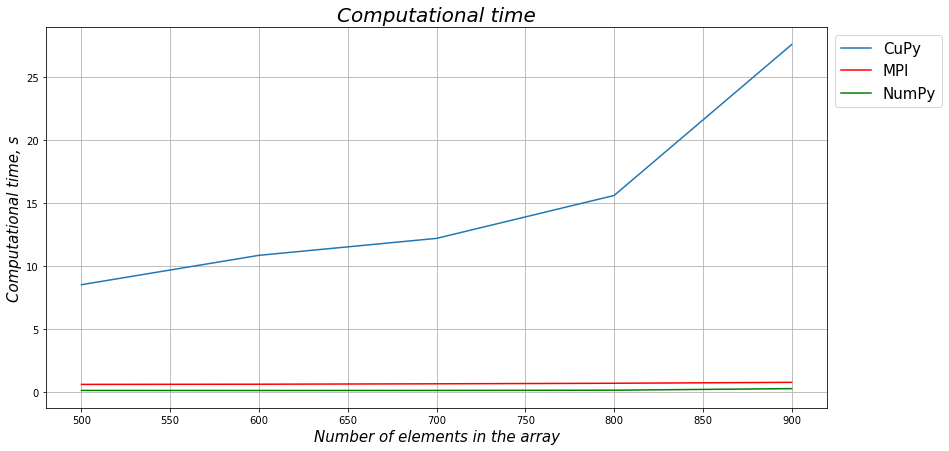

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.plot(number_of_steps, time_cp, label = 'CuPy')
ax.plot(number_of_steps, time_mpi, 'r', label = 'MPI')
ax.plot(number_of_steps, time_np, 'g', label = 'NumPy')
ax.set_title('Computational time', fontsize = 20, fontstyle = 'oblique')

plt.xlabel('Number of elements in the array', fontsize = 15, fontstyle = 'oblique')
plt.ylabel('Computational time, s', fontsize = 15, fontstyle = 'oblique')

plt.legend(prop={'size': 15}, bbox_to_anchor = (1, 1))
plt.grid(True)

plt.show()

I do not know why the computational time for CuPy is the largest in my case. Perhaps, the reason is that there is two video cards and there are no suitable drivers for the discrete one. The processor load, meanwhile, is max.

### Profiling

In [42]:
r = cp.linspace(0, 4, 1000)

In [43]:
import cProfile

cProfile.run('bifurcation_cupy(x0, r, last, number_of_steps)')

         1805004 function calls in 21.767 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   200000    0.178    0.000    0.647    0.000 <__array_function__ internals>:2(min_scalar_type)
        1   20.598   20.598   21.767   21.767 <ipython-input-41-884a6e67ec5e>:1(bifurcation_cupy)
        1    0.000    0.000   21.767   21.767 <string>:1(<module>)
     1000    0.007    0.000    0.007    0.000 basic.py:7(empty)
   200000    0.042    0.000    0.042    0.000 multiarray.py:583(min_scalar_type)
   602000    0.394    0.000    0.514    0.000 numeric.py:1816(isscalar)
        1    0.000    0.000   21.767   21.767 {built-in method builtins.exec}
   602000    0.121    0.000    0.121    0.000 {built-in method builtins.isinstance}
   200000    0.427    0.000    0.427    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' obj